In [2]:
pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import PyPDF2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader

2024-08-21 18:13:14.359687: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 18:13:14.359796: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 18:13:14.482943: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Function to extract text from PDF
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
    return text

In [5]:
# Prepare dataset
categories = []
texts = []

base_dir = '/kaggle/input/cv-dataset/dataset/data/data' 
for category_folder in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category_folder)
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            if filename.endswith('.pdf'):
                pdf_path = os.path.join(category_path, filename)
                text = extract_text_from_pdf(pdf_path)
                texts.append(text)
                categories.append(category_folder)

In [6]:
# Create DataFrame
df = pd.DataFrame({'resume_text': texts, 'category': categories})
df.head()

,resume_text,category
0,"PRE-PRESS GRAPHIC DESIGNER\nSummary\nCreative,...",DESIGNER
1,PRINCIPLE DESIGNER / OWNER\nProfessional Summa...,DESIGNER
2,PROJECT DESIGNER\nSummary\nTeam-oriented and c...,DESIGNER
3,INTERIOR DESIGNER\nSummary\nA results oriented...,DESIGNER
4,PRESENTATION DESIGNER\nSummary\nCustomer Servi...,DESIGNER


In [7]:
df["category"].value_counts()

category
BUSINESS-DEVELOPMENT      120
INFORMATION-TECHNOLOGY    120
FINANCE                   118
CHEF                      118
ACCOUNTANT                118
ADVOCATE                  118
ENGINEERING               118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

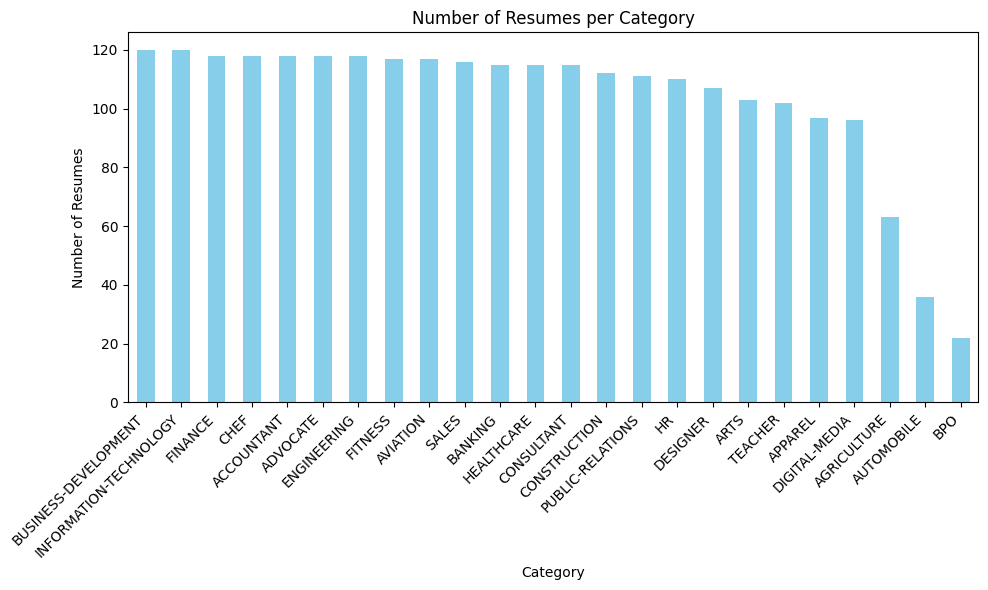

In [8]:
# Count the number of resumes in each category
category_counts = df['category'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Category')
plt.ylabel('Number of Resumes')
plt.title('Number of Resumes per Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()

In [9]:
# Encode labels
label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

In [10]:
# Convert text data into TF-IDF vectors for SMOTE
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['resume_text'])

In [11]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, df['category_encoded'])

In [12]:
# Inverse transform TF-IDF matrix back to text data
resampled_texts = [' '.join([tfidf_vectorizer.get_feature_names_out()[i] for i in row.indices])
                   for row in X_resampled]

# Create a DataFrame for the resampled data
df_resampled = pd.DataFrame({'resume_text': resampled_texts, 'category_encoded': y_resampled})


In [13]:
# Split the resampled data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(df_resampled['resume_text'], df_resampled['category_encoded'], test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the datasets (Using the synthetic resume text)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(X_val), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
class ResumeDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create PyTorch datasets
train_dataset = ResumeDataset(train_encodings, list(y_train))
val_dataset = ResumeDataset(val_encodings, list(y_val))
test_dataset = ResumeDataset(test_encodings, list(y_test))

In [15]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to=[] 
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [29]:
from sklearn.metrics import accuracy_score, f1_score

# Trainer API from Hugging Face
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ResumeDataset(train_encodings, list(y_train)),
    eval_dataset=ResumeDataset(val_encodings, list(y_val)),
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1)),
        'f1': f1_score(p.label_ids, p.predictions.argmax(-1), average='weighted')
    }
)

In [30]:
import os

os.environ["WANDB_DISABLED"] = "true"

# Train the model
trainer.train()

# Evaluate the model on the test set
test_results = trainer.evaluate(ResumeDataset(test_encodings, list(y_test)))
print(f"Test Accuracy: {test_results['eval_accuracy']}")
print(f"Test F1 Score: {test_results['eval_f1']}")

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.227800,2.238719,0.456019,0.394066
2,1.373900,1.640561,0.557870,0.526110
3,1.274500,1.347915,0.662037,0.635306


Test Accuracy: 0.6620370370370371
Test F1 Score: 0.6485545808972485
